In [17]:
import pickle
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.markers as mrk
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import numpy as np
import matplotlib.colors as mcolors
from torch.utils.data import TensorDataset, DataLoader
# import pywt
import math
import tqdm
import h5py
import os
import random
from collections import defaultdict
import yaml
import pprint
from easydict import EasyDict as edict
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from attack import Attack, flatten_dataset,normalize_tensor, max_peak
from scipy.signal import find_peaks

run_config = yaml.load(open('configs/config.yaml'), Loader=yaml.FullLoader)

# attack_list = run_config.get('attacks', [])
attack_list = ['attack_contrib', 'attack_distrib', 'highest_contrib']
tensor_list = ['shap', 'cp']
dataset_list = run_config.get('datasets', [])
model_list = run_config.get('models', [])

In [3]:
def load_results_dict(h5f):
    results_dict = {}
    for dataset_name in h5f.keys():
        dataset_grp = h5f[dataset_name]
        results_dict[dataset_name] = {}

        for model_name in dataset_grp.keys():
            model_grp = dataset_grp[model_name]
            results_dict[dataset_name][model_name] = {}
            
            if "model_parameters" in model_grp:
                model_params_grp = model_grp["model_parameters"]
                results_dict[dataset_name][model_name]["model_parameters"] = {
                    param_name: torch.tensor(model_params_grp[param_name][...]) 
                    for param_name in model_params_grp.keys()
                }
            for attack in model_grp.keys():
                if attack == "model_parameters":
                    continue
                attack_grp = model_grp[attack]
                results_dict[dataset_name][model_name][attack] = {}

                for key in attack_grp.keys():
                    if key == "dyn_decision_tensor":
                        dyn_tensor_grp = attack_grp[key]
                        results_dict[dataset_name][model_name][attack][key] = [
                            torch.tensor(dyn_tensor_grp[f'tensor_{idx}'][...]) for idx in range(len(dyn_tensor_grp.keys()))
                        ]
                    else:
                        results_dict[dataset_name][model_name][attack][key] = torch.tensor(attack_grp[key][...])

    return results_dict

def load_config(h5f):
    out_dict = {}
    for key, item in h5f.items():
        if isinstance(item, h5py.Group):
            out_dict[key] = load_config(item)
        else:
            data = item[()]
            if isinstance(data, bytes):
                out_dict[key] = data.decode('utf-8')
            elif isinstance(data, np.ndarray):
                if data.ndim == 0:
                    out_dict[key] = data.item()
                else:
                    out_dict[key] = data
            else:
                out_dict[key] = data
    return out_dict


In [54]:
# results_dict = load_results_dict(h5py.File('results/pipeline/results.h5', 'r'))
# loaded_config = load_config(h5py.File('results/pipeline/config.h5', 'r'))

# print(results_dict['euma']['dlinear'].keys())

# shap_values = results_dict['euma']['dlinear']['model_parameters']['shap_values']
# print(shap_values)

loaded_results_dict = load_results_dict(h5py.File('results/save/results.h5', 'r'))
loaded_config = load_config(h5py.File('results/save/config.h5', 'r'))
res_dataset_model = loaded_results_dict['euma']['dlinear']
results = {}
parameters={}

for attack in res_dataset_model.keys():
    if attack == 'model_parameters':
        parameters = res_dataset_model[attack]
        # model_parameters = model_parameters[attack]
    elif attack=='parameters': # same as model_parameters, need to be fixed in next runs
        continue
    else:
        results[attack] = res_dataset_model[attack]

print(results.keys())
print(parameters.keys())
# print(results_dict['euma']['dlinear']['model_parameters'].keys())
# print(loaded_config)
shap_values = loaded_results_dict['euma']['dlinear']['model_parameters']['shap_values']
# print(shap_values)

dict_keys(['attack_contrib_10_0.05_cp', 'attack_contrib_10_0.05_shap', 'attack_contrib_10_0.1_cp', 'attack_contrib_10_0.1_shap', 'attack_contrib_12_0.05_cp', 'attack_contrib_12_0.05_shap', 'attack_contrib_12_0.1_cp', 'attack_contrib_12_0.1_shap', 'attack_distrib_10_0.05_cp', 'attack_distrib_10_0.05_shap', 'attack_distrib_10_0.1_cp', 'attack_distrib_10_0.1_shap', 'attack_distrib_12_0.05_cp', 'attack_distrib_12_0.05_shap', 'attack_distrib_12_0.1_cp', 'attack_distrib_12_0.1_shap', 'bim_100_0.05', 'bim_100_0.1', 'bim_10_0.05', 'bim_10_0.1', 'bim_20_0.05', 'bim_20_0.1', 'bim_30_0.05', 'bim_30_0.1', 'bim_40_0.05', 'bim_40_0.1', 'bim_50_0.05', 'bim_50_0.1', 'bim_60_0.05', 'bim_60_0.1', 'bim_70_0.05', 'bim_70_0.1', 'bim_80_0.05', 'bim_80_0.1', 'bim_90_0.05', 'bim_90_0.1', 'fgsm_0_0.05', 'fgsm_0_0.1', 'highest_contrib_10_0.05_cp', 'highest_contrib_10_0.05_shap', 'highest_contrib_10_0.1_cp', 'highest_contrib_10_0.1_shap', 'highest_contrib_12_0.05_cp', 'highest_contrib_12_0.05_shap', 'highest_con

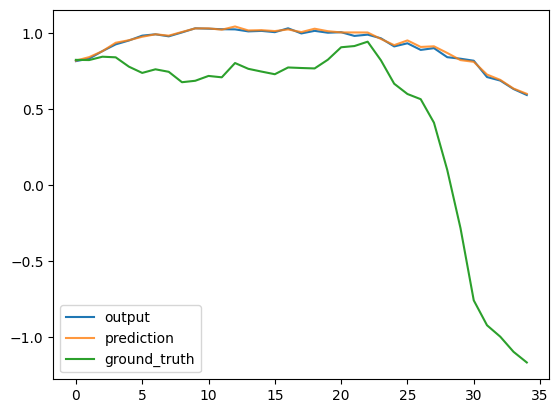

In [16]:
sample=27
plt.plot(output[sample], label='output')
plt.plot(prediction[sample], label='prediction', alpha=0.8)
plt.plot(ground_truth[sample], label='ground_truth')
plt.legend()

# Formula

## Sum of the horizon :
$$
\forall t,l,h, \quad \text{H}_{t,l} = {\sum_{h} \left| \text{SHAP}(t, l, h) \right|}
$$

## attack contrib :
$$
\forall t, l, h,\quad \text{normalized\_tensor}(t,l,h) = \frac{\text{SHAP}_{t,l,h}}{\sum_{t'} H_{t',l}}
$$
$$
\forall t, l,\quad \text{tensor\_sum}_{t,l} = \sum_{h} \left| \text{normalized\_tensor}(t,l,h) \right|
$$
$$
\text{attack\_contrib} = \max_{t,l} ( \text{tensor\_sum}_{t,l})
$$

## attack distrib :
$$
\forall t,l, \quad \text{tensor\_sum}_{t}(l) = \frac{\text{H}_{t,l}}{\sum_{l} \text{H}_{t,l}}
$$
$$
\forall t,l \quad \text{distrib}_{t}(l)= \frac{\text{tensor\_sum}_{t}(l)}{\sum_{l} \left| \text{tensor\_sum}_{t}(l) \right|}
$$
$$
\text{attack\_distrib} = \max_{t,l}( \text{distrib}_{t}(l))
$$

## highest_contrib :
$$
\forall t,l, \quad \text{tensor\_sum}(t,l) = {\sum_{t,l} \left| \text{H}_{t,l} \right|}
$$
$$
\forall t,l, \quad \text{highest\_contrib} = \max_{t,l}(\text{tensor\_sum}(t,l))
$$


# Graphs

## Metrics x Number of points poisoned

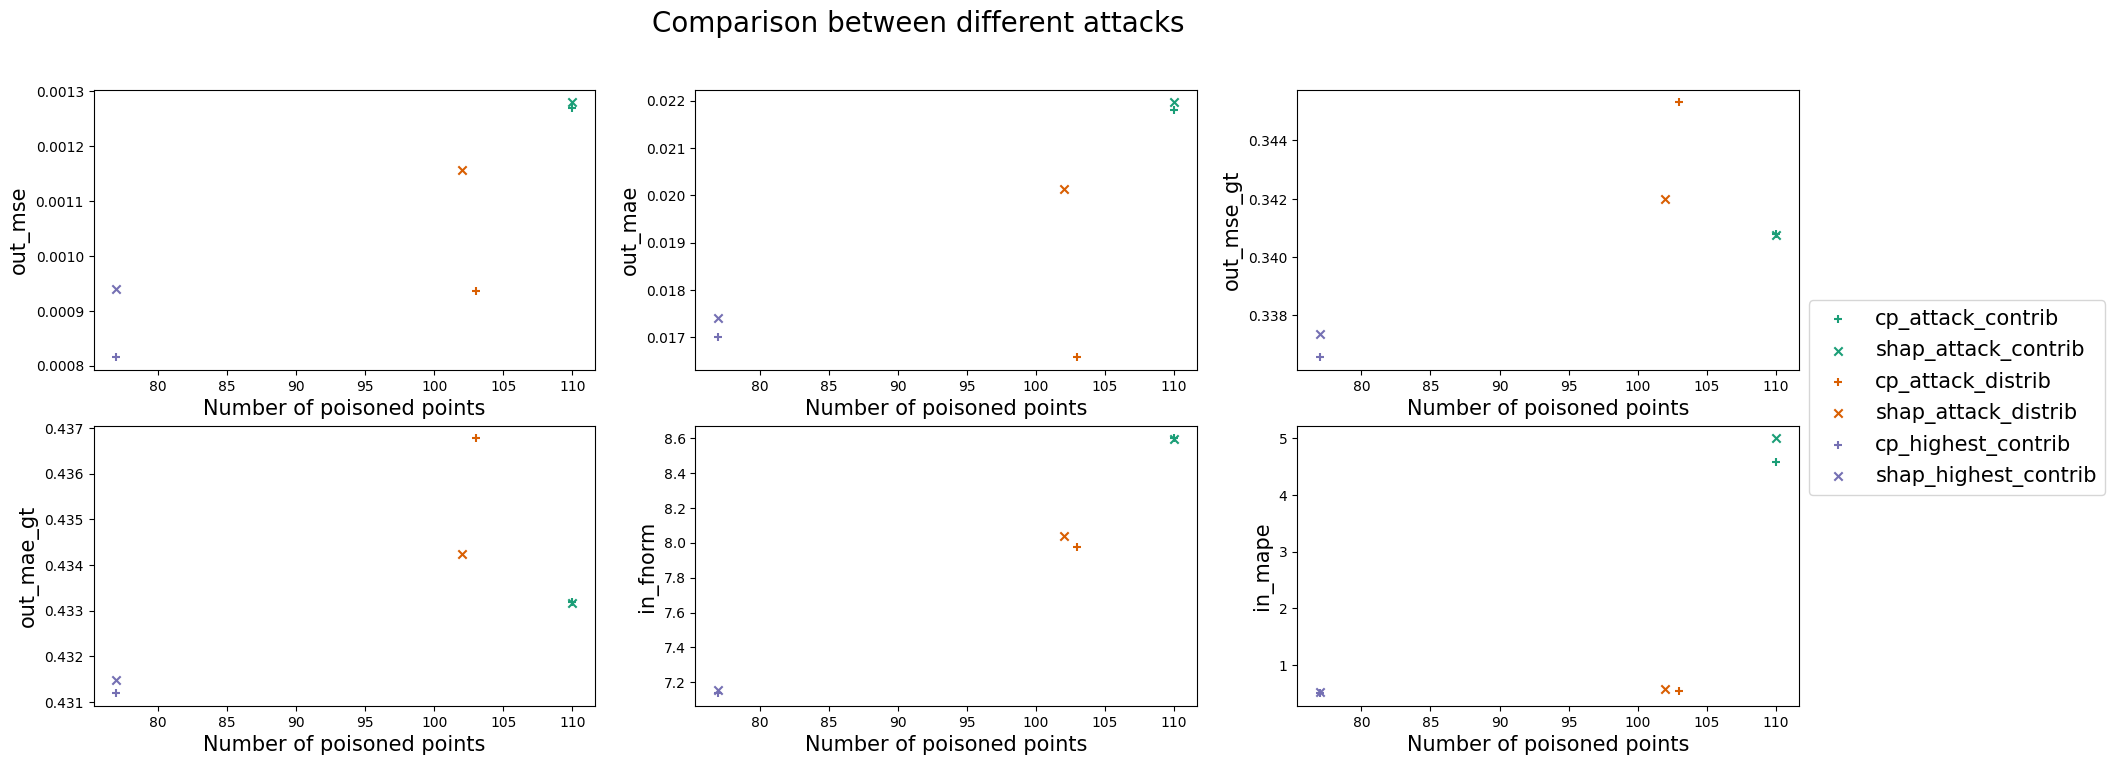

In [41]:
markers = ['+', 'x'] 
cmap = plt.get_cmap('Dark2')
[cmap(i / 5) for i in range(5)]
metrics = ['out_mse', 'out_mae','out_mse_gt', 'out_mae_gt', 'in_fnorm', 'in_mape']
row=3
col=3
eps,num = 0.1,10
fig, axs = plt.subplots(2,3,figsize=(22,8))
for j in range(6):
    for idx, attack in enumerate(attack_list):
        for i, tensor in enumerate(tensor_list):
            marker = markers[i % len(markers)]  
            metric = results[f'{attack}_{num}_{eps}_{tensor}'][metrics[j]]
            num_targeted = results[f'{attack}_{num}_{eps}_{tensor}']["num_targeted"]

            axs[j//row,j%col].scatter(num_targeted,metric, marker=marker, label=f'{tensor}_{attack}', color=cmap(idx))

    axs[j//row,j%col].set_ylabel(f'{metrics[j]}',fontsize=15)
    axs[j//row,j%col].set_xlabel(f'Number of poisoned points',fontsize=15)

plt.legend( loc='center left',
            bbox_to_anchor=(1.02, 1.1),
            borderaxespad=0.0,
            fontsize=15)
fig.suptitle('Comparison between different attacks', fontsize=20)
plt.show()

| | attack contrib | attack distrib | highest contrib | roll_var | roll_var_dyn|
| :---: | :---: | :---: | :---: | :---: | :---: |
| shap | points/stealh/gt | pred | gt/pred | points/stealth | stealth/pred |
| cp | pred | points/stealth/gt | points/stealth | gt/pred | gt |


## Input Poisoning comparison

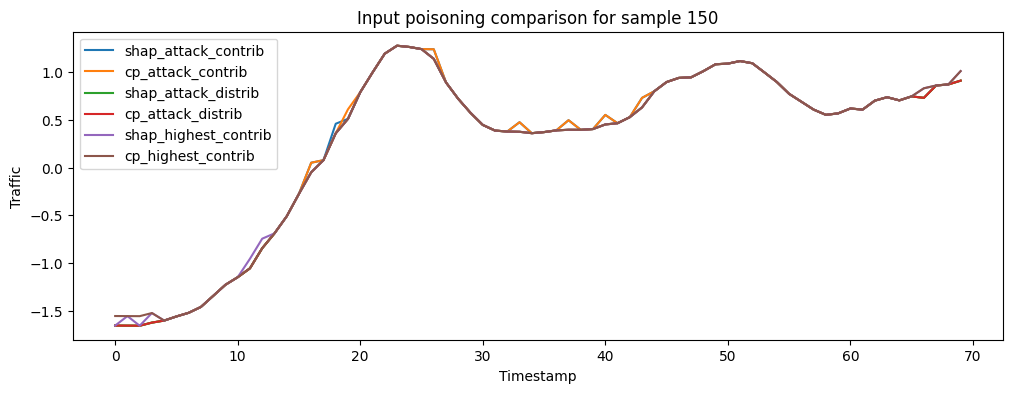

In [20]:
sample = 150
# cmap = plt.get_cmap('Dark2')
# [cmap(i / 5) for i in range(5)]

plt.figure(figsize=(12, 4))
eps,num = 0.1,10
for idx, attack in enumerate(attack_list):
    for i, tensor in enumerate(tensor_list):
        marker = markers[i % len(markers)]  
        X_adv = results[f'{attack}_{num}_{eps}_{tensor}']["input"]
        # if attack != 'attack_rolling_var' and attack != 'attack_rolling_var_dynamic':
        # if attack=='attack_rolling_var_dynamic':
        plt.plot(X_adv[sample], label=f'{tensor}_{attack}')
plt.xlabel('Timestamp')
plt.ylabel('Traffic')
plt.title(f'Input poisoning comparison for sample {sample}')
plt.legend()
plt.show()

## Output Poisoning comparison

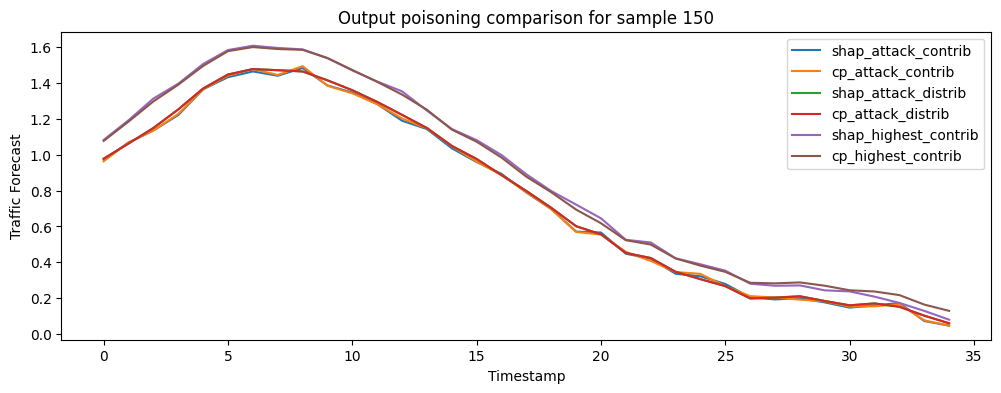

In [21]:
sample = 150
# cmap = plt.get_cmap('Dark2')
# [cmap(i / 5) for i in range(5)]

plt.figure(figsize=(12, 4))
eps,num = 0.1,10
for idx, attack in enumerate(attack_list):
    for i, tensor in enumerate(tensor_list):
        marker = markers[i % len(markers)] 
        output = results[f'{attack}_{num}_{eps}_{tensor}']["output"]
        # if attack != 'attack_rolling_var' and attack != 'attack_rolling_var_dynamic':
        # if attack=='highest_contrib':
        plt.plot(output[sample], label=f'{tensor}_{attack}')
plt.xlabel('Timestamp')
plt.ylabel('Traffic Forecast')
plt.title(f'Output poisoning comparison for sample {sample}')
plt.legend()
plt.show()

## Output and Input comparison

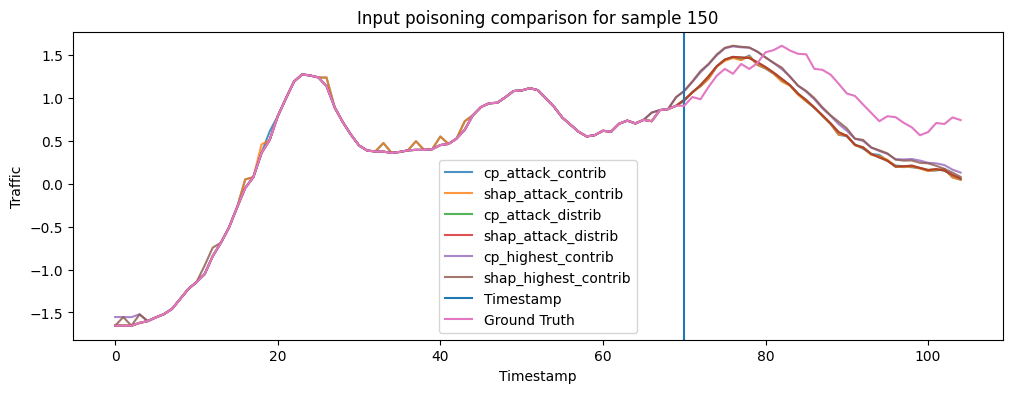

In [55]:
sample = 150

plt.figure(figsize=(12, 4))
eps,num = 0.1,10
for idx, attack in enumerate(attack_list):
    for i, tensor in enumerate(tensor_list):
        marker = markers[i % len(markers)]  
        X_adv = results[f'{attack}_{num}_{eps}_{tensor}']["input"]
        output = results[f'{attack}_{num}_{eps}_{tensor}']["output"]
        # print(X_adv.shape,output.shape)
        join = torch.cat((X_adv, output), dim=1)
        # if attack != 'attack_rolling_var' and attack != 'attack_rolling_var_dynamic':
        # if attack=='attack_rolling_var_dynamic':
        plt.plot(join[sample], label=f'{tensor}_{attack}', alpha = 0.8)
plt.axvline(x=X_adv.shape[1], label='Timestamp')
join = torch.cat((parameters['X_test'], parameters['y_test']), dim=1)
plt.plot(join[sample], label=f'Ground Truth')
plt.xlabel('Timestamp')
plt.ylabel('Traffic')
plt.title(f'Input poisoning comparison for sample {sample}')
plt.legend()
plt.show()


## Spatial Comparison

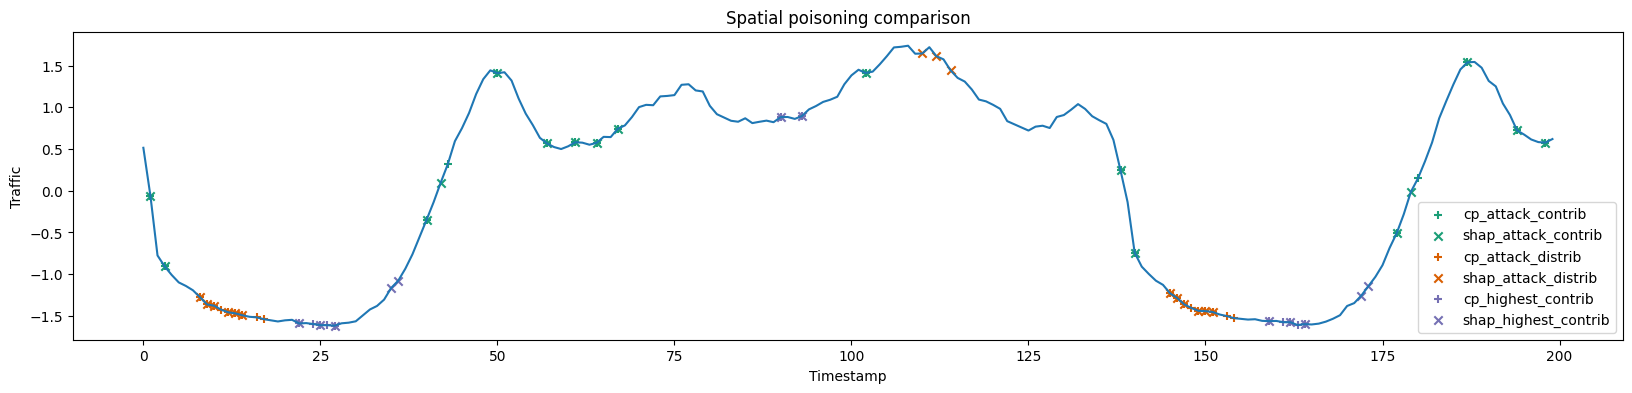

In [56]:
cmap = plt.get_cmap('Dark2')
[cmap(i / 5) for i in range(5)]
markers = ['+', 'x'] 
beg = 400
end = 600
X_flat = loaded_config['Dataset']['euma']['X_test_flatten'][beg:end]
attack_list = ["attack_contrib", "attack_distrib", "highest_contrib"]
tensor_list = ['cp','shap']
plt.figure(figsize=(20, 4))

eps,num = 0.1,10
for idx, attack in enumerate(attack_list):
    for i, tensor in enumerate(tensor_list):
        marker = markers[i % len(markers)]
        targeted_points = results[f'{attack}_{num}_{eps}_{tensor}']["target_points"]
        mask = (targeted_points >= beg) & (targeted_points <= end)
        targeted_points = targeted_points[mask] - beg
        plt.scatter(targeted_points, X_flat[targeted_points], marker=marker, color=cmap(idx), label=f'{tensor}_{attack}')

plt.plot(X_flat)
plt.xlabel('Timestamp')
plt.ylabel('Traffic')
plt.title(f'Spatial poisoning comparison')
plt.legend()
plt.show()

# Decision Tensor Comparison

## Attack Contrib

/tmp/ipykernel_470173/548762980.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,0].set_xticklabels([f"{y + first_occurence:.0f}" for y in xticks])  # Relabel ticks
/tmp/ipykernel_470173/548762980.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,0].set_xticklabels([f"{y + first_occurence:.0f}" for y in xticks])  # Relabel ticks


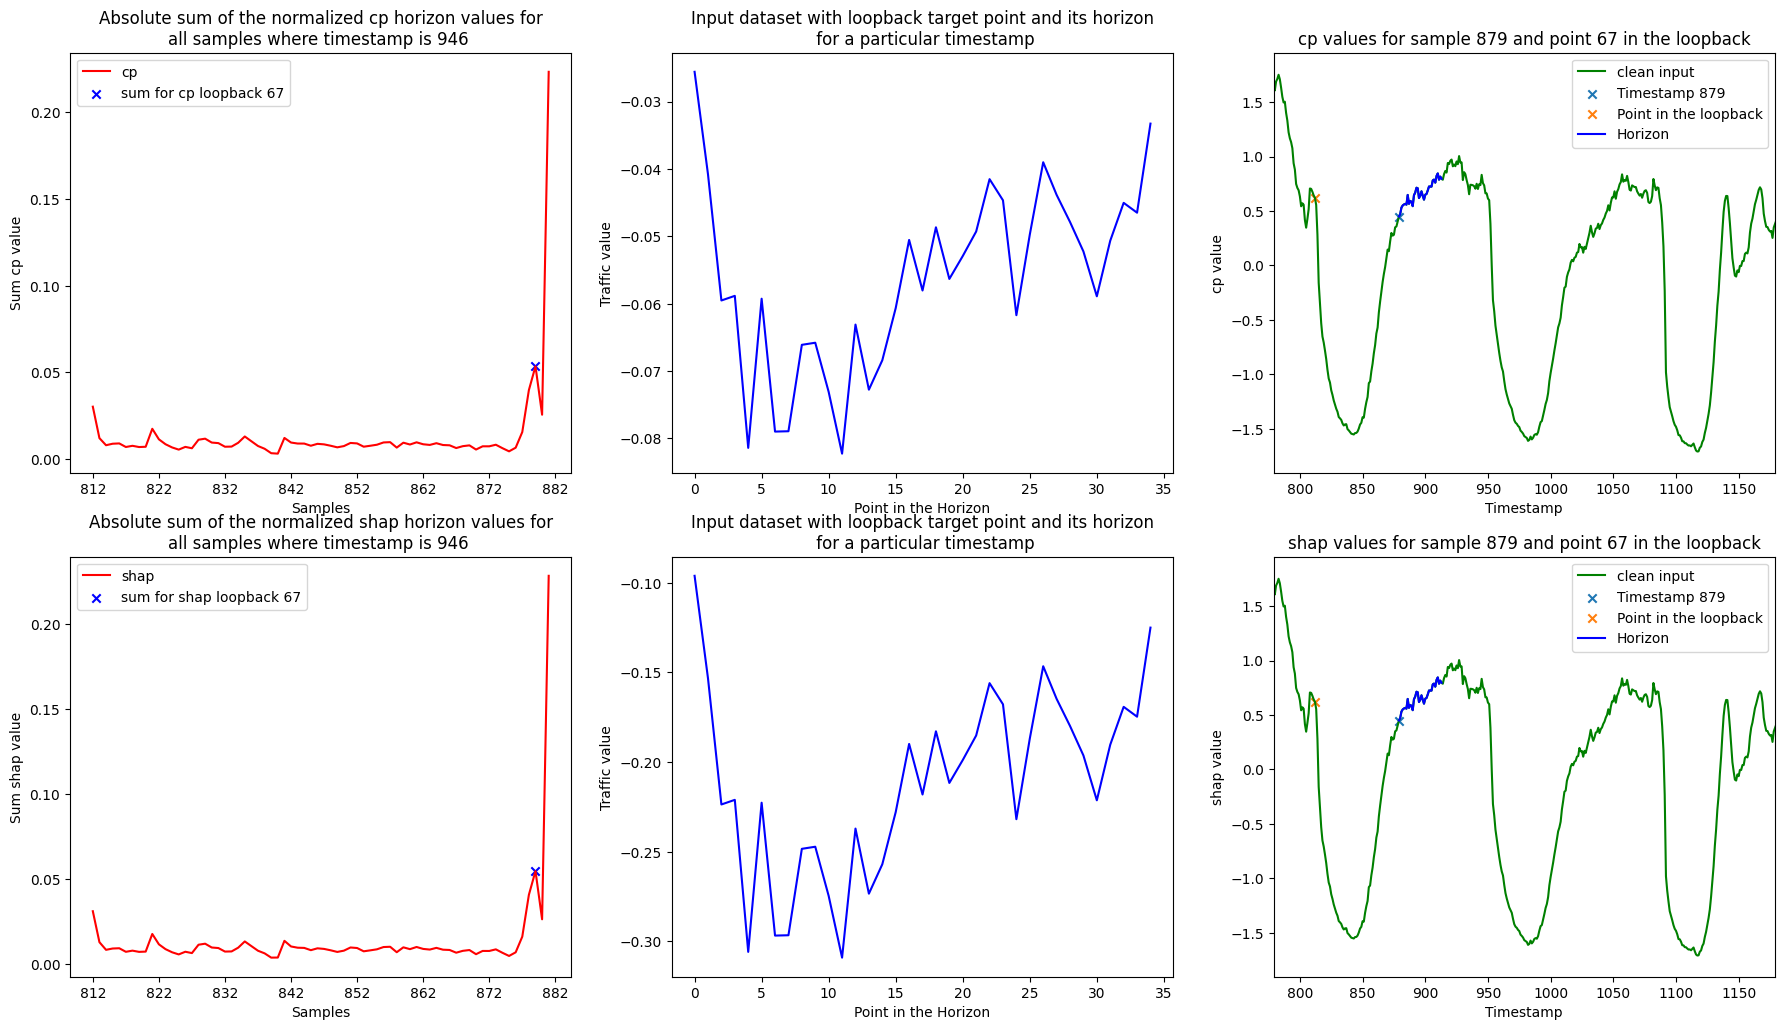

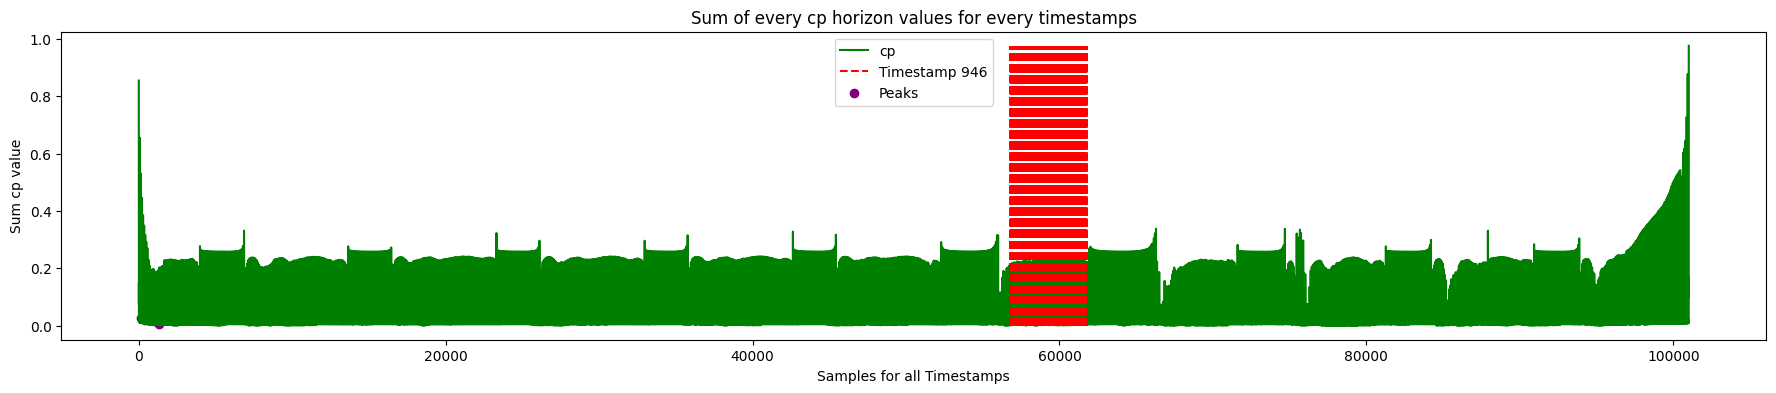

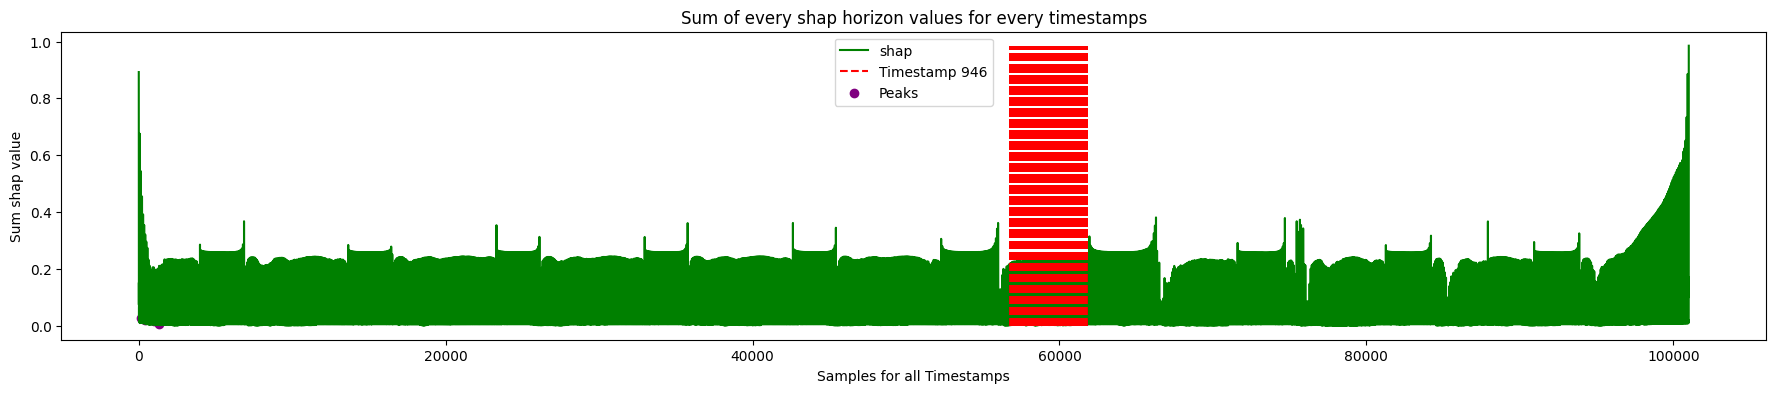

In [59]:
shap = parameters["shap_values"]
cp = parameters["cp_values"]
cln_input_flat = flatten_dataset(parameters["X_test"])
cln = [cp, shap]
dim1 = shap.shape[1]
dim2 = shap.shape[2]

sample = 879
loopback = 67
timestamp = sample + loopback
first_occurence = sample - loopback
attack='attack_contrib'

eps,num = 0.1,10

fig, axs = plt.subplots(2,3,figsize=(22,12))
for i, tensor in enumerate(tensor_list):
    decision_tensor = results[f'{attack}_{num}_{eps}_{tensor}']["decision_tensor"]
    indices = results[f'{attack}_{num}_{eps}_{tensor}']["indices"]
    cln_tensor = cln[i]

    ### Input dataset with sample and loopback point
    axs[i,2].plot(cln_input_flat, color='green', label='clean input')
    axs[i,2].scatter(sample, cln_input_flat[sample], marker='x', label=f'Timestamp {sample}')
    axs[i,2].scatter(first_occurence, cln_input_flat[first_occurence], marker='x', label=f'Point in the loopback')
    axs[i,2].plot(range(sample, sample + dim2),cln_input_flat[sample:sample+dim2], color='blue', label='Horizon')
    axs[i,2].set_xlim(sample-100,sample+300)
    axs[i,2].set_xlabel('Timestamp')
    axs[i,2].legend()
    axs[i,2].set_ylabel(f'{tensor} value')
    axs[i,2].set_title(f'{tensor} values for sample {sample} and point {loopback} in the loopback')

    ### tensor values for a particular sample and loopback
    axs[i,1].plot(cln_tensor[sample,loopback,:], color='blue')
    # axs[i,2].plot(n_tensor[sample,loopback,:])
    axs[i,1].set_xlabel('Point in the Horizon')
    axs[i,1].set_ylabel(f'Traffic value')
    axs[i,1].set_title(f'Input dataset with loopback target point and its horizon\n'
                       f' for a particular timestamp'
                       )

    ### sum of the horizon's tensor values for a timestamp
    pool = [(dim1)*(x + first_occurence) + x for x in range(dim1)]
    # print(pool)
    sum_timestamp = decision_tensor[pool]
    axs[i,0].plot(sum_timestamp, color='red', label=f'{tensor}')
    xticks = axs[i,0].get_xticks()               # Get current tick locations
    axs[i,0].set_xticklabels([f"{y + first_occurence:.0f}" for y in xticks])  # Relabel ticks
    axs[i,0].set_xlabel('Samples')
    axs[i,0].scatter(loopback,sum_timestamp[loopback], marker='x', color='blue', label=f'sum for {tensor} loopback {loopback}')
    axs[i,0].set_ylabel(f'Sum {tensor} value')
    axs[i,0].set_title( f'Absolute sum of the normalized {tensor} horizon values for\n'
                        f'all samples where timestamp is {timestamp} '
    )
    axs[i,0].legend()

fig.show()

### decison tensor
for i, tensor in enumerate(tensor_list):
    decision_tensor = results[f'{attack}_{num}_{eps}_{tensor}']["decision_tensor"]
    indices = results[f'{attack}_{num}_{eps}_{tensor}']["indices"]
    plt.figure(figsize=(22,4))
    pool = pool*70
    plt.plot(decision_tensor, color='green', label=f'{tensor}')
    plt.vlines(pool, ymin=decision_tensor.min(), ymax=decision_tensor.max(), color='red',linestyle='--', label=f'Timestamp {timestamp}')
    plt.scatter(indices,decision_tensor[indices], color='purple', label=f'Peaks')
    # plt.set_xlim(56000,62000)
    # plt.set_xscale('log')
    plt.xlabel('Samples for all Timestamps')
    plt.ylabel(f'Sum {tensor} value')
    plt.title(f'Sum of every {tensor} horizon values for every timestamps')
    plt.legend()
    plt.show()

## Highest Contrib

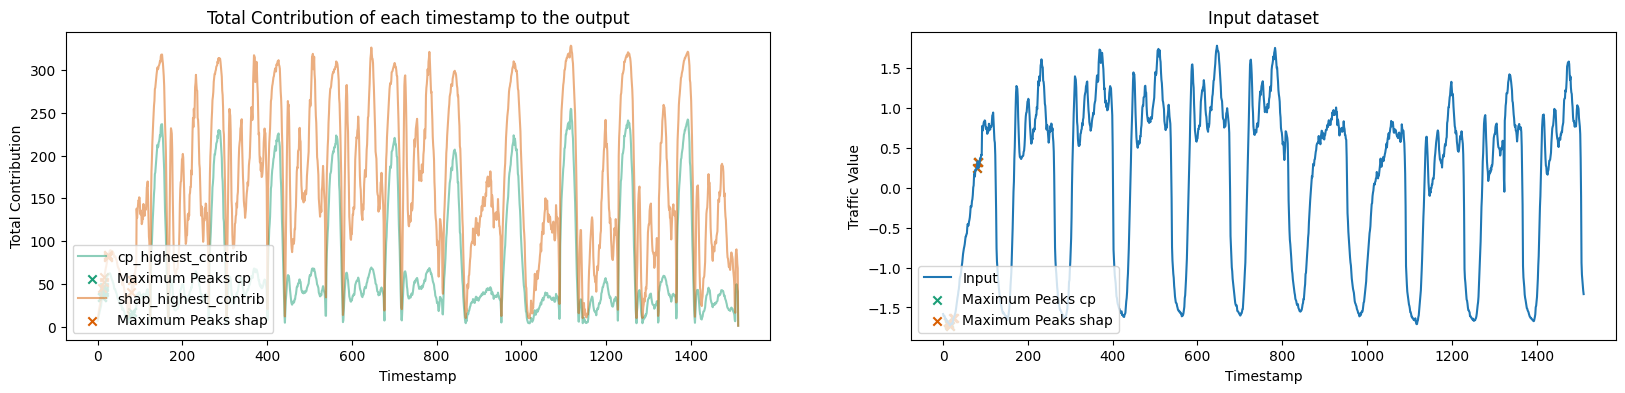

In [60]:
distance = 24
cmap = plt.get_cmap('Dark2')
[cmap(i / 2) for i in range(2)]
cln_input_flat = flatten_dataset(parameters["X_test"])

attack = 'highest_contrib'
fig, axs = plt.subplots(1,2,figsize=(20,4))
for i, tensor in enumerate(tensor_list):
   
    decision_tensor = results[f'{attack}_{num}_{eps}_{tensor}']["decision_tensor"]
    indices = results[f'{attack}_{num}_{eps}_{tensor}']["indices"]

    ## Once time plot
    if i==0:
        axs[1].plot(cln_input_flat, label='Input')


    ## Points in the decision tensor
    axs[0].plot(decision_tensor, label=f'{tensor}_{attack}', color=cmap(i), alpha = 0.5)
    # axs[0].scatter(indices, decision_tensor[indices], color='red',marker='X', label='Maximum Peaks')
    axs[0].scatter(indices, decision_tensor[indices], color=cmap(i), marker='x', label=f'Maximum Peaks {tensor}')
    axs[0].set_xlabel('Timestamp')
    axs[0].set_ylabel('Total Contribution')
    axs[0].set_title(f'Total Contribution of each timestamp to the output')
    axs[0].legend(loc='lower left')

    ## Points in the input dataset
    axs[1].scatter(indices, cln_input_flat[indices], color=cmap(i),marker='x', label=f'Maximum Peaks {tensor}')
    # axs[1].scatter(decision_tensor, decision_tensor[indices], color=cmap(i), marker='H', label=f'Local Maximum Peaks {tensor}')
    axs[1].set_xlabel('Timestamp')
    axs[1].set_ylabel('Traffic Value')
    axs[1].set_title(f'Input dataset')
    axs[1].legend(loc='lower left')
fig.show()

## Attack Distrib


/tmp/ipykernel_470173/3082019749.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,0].set_xticklabels([f"{y + first_occurence:.0f}" for y in xticks])  # Relabel ticks
/tmp/ipykernel_470173/3082019749.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,0].set_xticklabels([f"{y + first_occurence:.0f}" for y in xticks])  # Relabel ticks


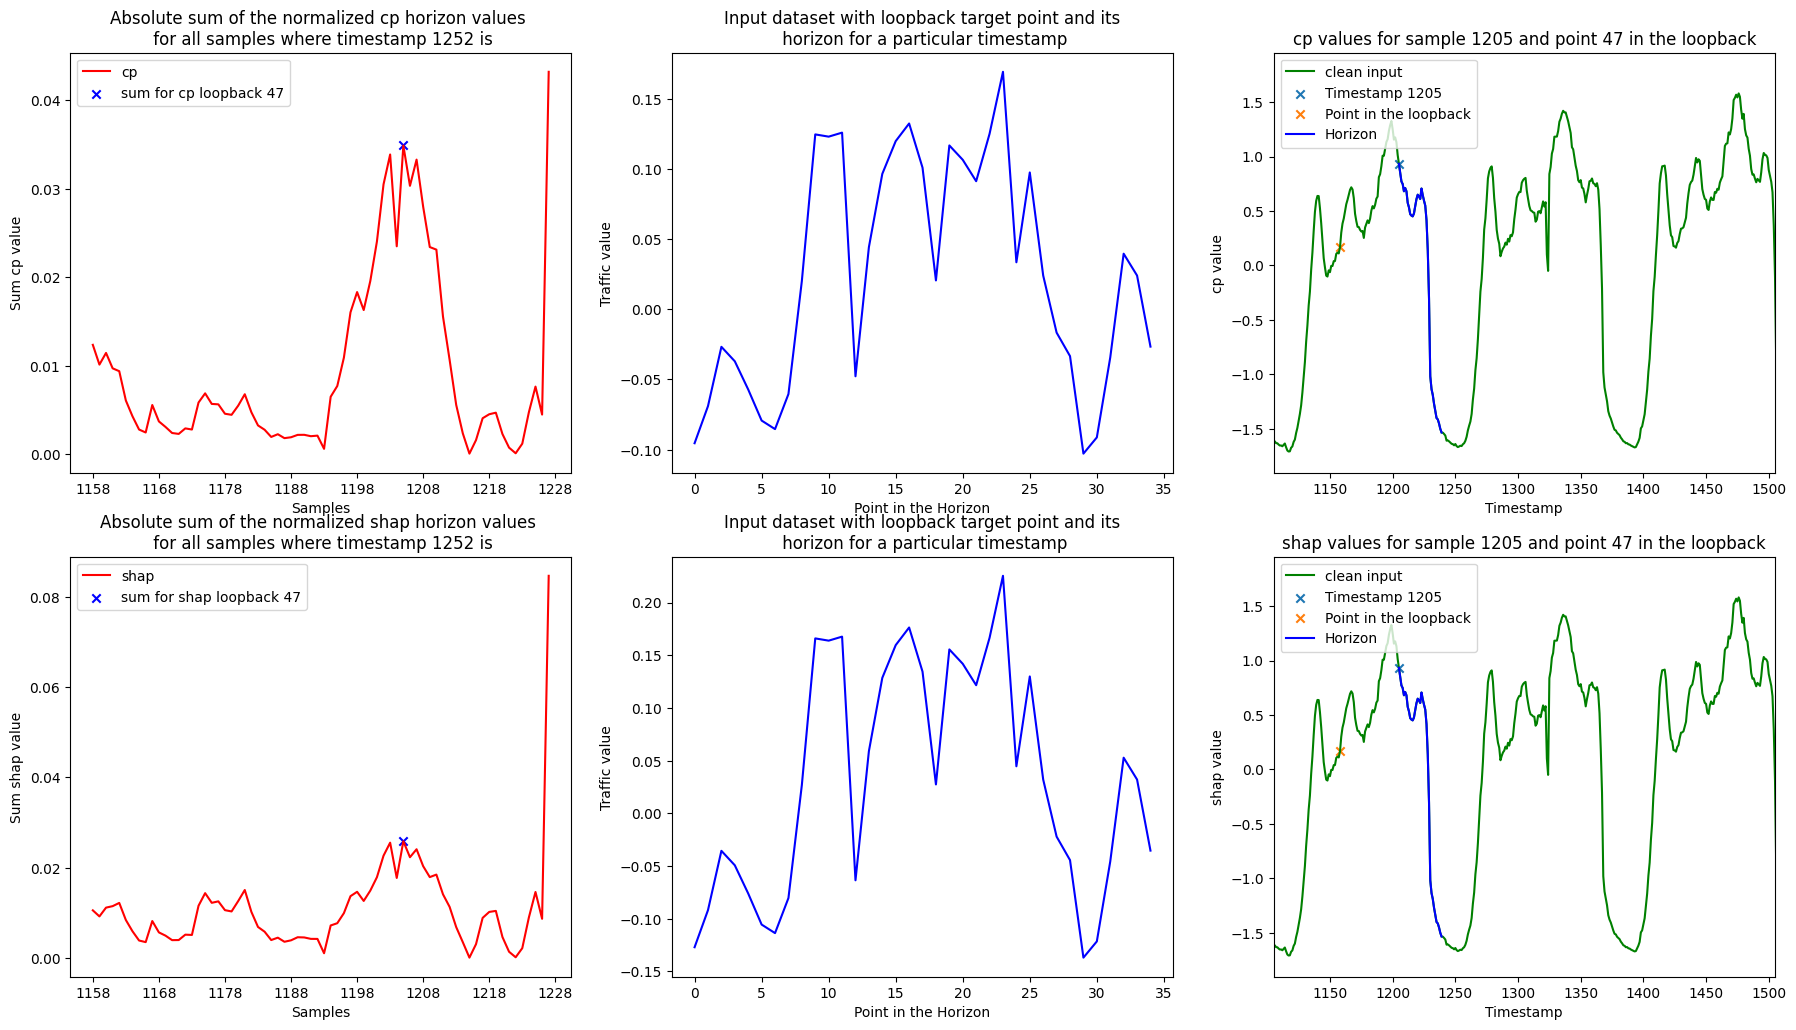

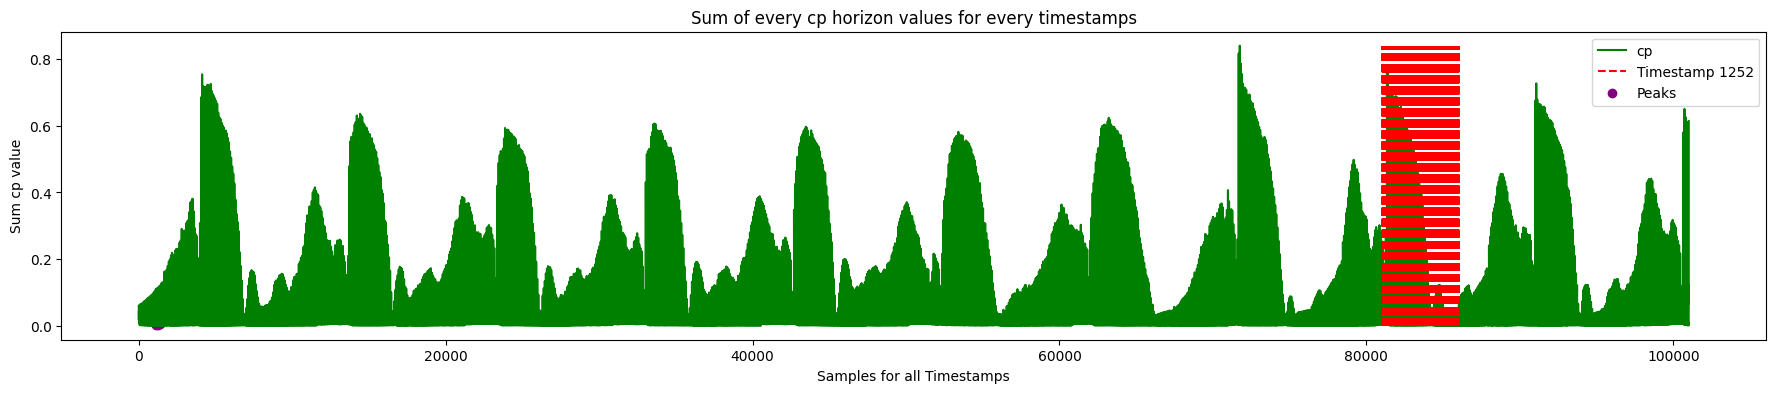

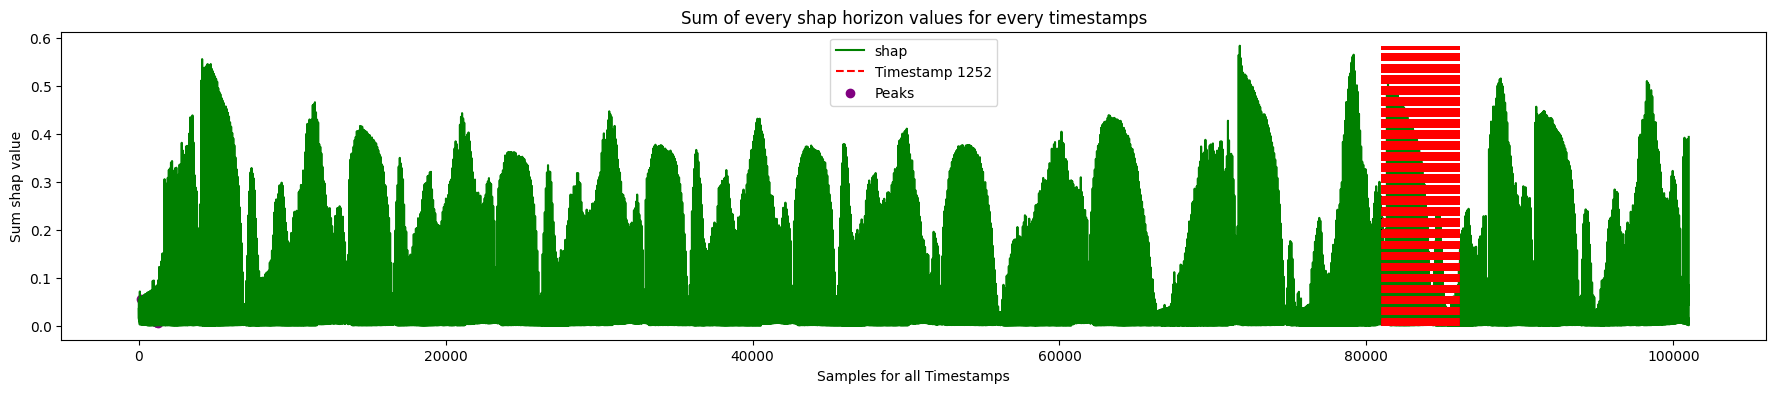

In [61]:
shap = parameters["shap_values"]
cp = parameters["cp_values"]
cln_input_flat = flatten_dataset(parameters["X_test"])
cln = [cp, shap]
dim1 = shap.shape[1]
dim2 = shap.shape[2]

sample = 1205
loopback = 47
timestamp = sample + loopback
first_occurence = sample - loopback
attack='attack_distrib'


fig, axs = plt.subplots(2,3,figsize=(22,12))
for i, tensor in enumerate(tensor_list):
    decision_tensor = results[f'{attack}_{num}_{eps}_{tensor}']["decision_tensor"]
    indices = results[f'{attack}_{num}_{eps}_{tensor}']["indices"]
    cln_tensor = cln[i]

    ### Input dataset with sample and loopback point
    axs[i,2].plot(cln_input_flat, color='green', label='clean input')
    axs[i,2].scatter(sample, cln_input_flat[sample], marker='x', label=f'Timestamp {sample}')
    axs[i,2].scatter(first_occurence, cln_input_flat[first_occurence], marker='x', label=f'Point in the loopback')
    axs[i,2].plot(range(sample, sample + dim2),cln_input_flat[sample:sample+dim2], color='blue', label='Horizon')
    axs[i,2].set_xlim(sample-100,sample+300)
    axs[i,2].set_xlabel('Timestamp')
    axs[i,2].legend()
    axs[i,2].set_ylabel(f'{tensor} value')
    axs[i,2].set_title(f'{tensor} values for sample {sample} and point {loopback} in the loopback')

    ### tensor values for a particular sample and loopback
    axs[i,1].plot(cln_tensor[sample,loopback,:], color='blue')
    # axs[i,2].plot(n_tensor[sample,loopback,:])
    axs[i,1].set_xlabel('Point in the Horizon')
    axs[i,1].set_ylabel(f'Traffic value')
    axs[i,1].set_title(f'Input dataset with loopback target point and its\n'
                       f' horizon for a particular timestamp')

    ### sum of the horizon's tensor values for a timestamp
    pool = [(dim1)*(x + first_occurence) + x for x in range(dim1)]
    # print(pool)
    sum_timestamp = decision_tensor[pool]
    axs[i,0].plot(sum_timestamp, color='red', label=f'{tensor}')
    xticks = axs[i,0].get_xticks()               # Get current tick locations
    axs[i,0].set_xticklabels([f"{y + first_occurence:.0f}" for y in xticks])  # Relabel ticks
    axs[i,0].set_xlabel('Samples')
    axs[i,0].scatter(loopback,sum_timestamp[loopback], marker='x', color='blue', label=f'sum for {tensor} loopback {loopback}')
    axs[i,0].set_ylabel(f'Sum {tensor} value')
    axs[i,0].set_title(f'Absolute sum of the normalized {tensor} horizon values \n'
                       f' for all samples where timestamp {timestamp} is')
    axs[i,0].legend()

fig.show()

### decison tensor
for i, tensor in enumerate(tensor_list):
    decision_tensor = results[f'{attack}_{num}_{eps}_{tensor}']["decision_tensor"]
    indices = results[f'{attack}_{num}_{eps}_{tensor}']["indices"]
    plt.figure(figsize=(22,4))
    pool = pool*70
    plt.plot(decision_tensor, color='green', label=f'{tensor}')
    plt.vlines(pool, ymin=decision_tensor.min(), ymax=decision_tensor.max(), color='red',linestyle='--', label=f'Timestamp {timestamp}')
    plt.scatter(indices,decision_tensor[indices], color='purple', label=f'Peaks')
    # plt.set_xlim(56000,62000)
    # plt.set_xscale('log')
    plt.xlabel('Samples for all Timestamps')
    plt.ylabel(f'Sum {tensor} value')
    plt.title(f'Sum of every {tensor} horizon values for every timestamps')
    plt.legend()
    plt.show()

## Rolling variance 

tensor([903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916,
        917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929])
tensor([194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
        208, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582])


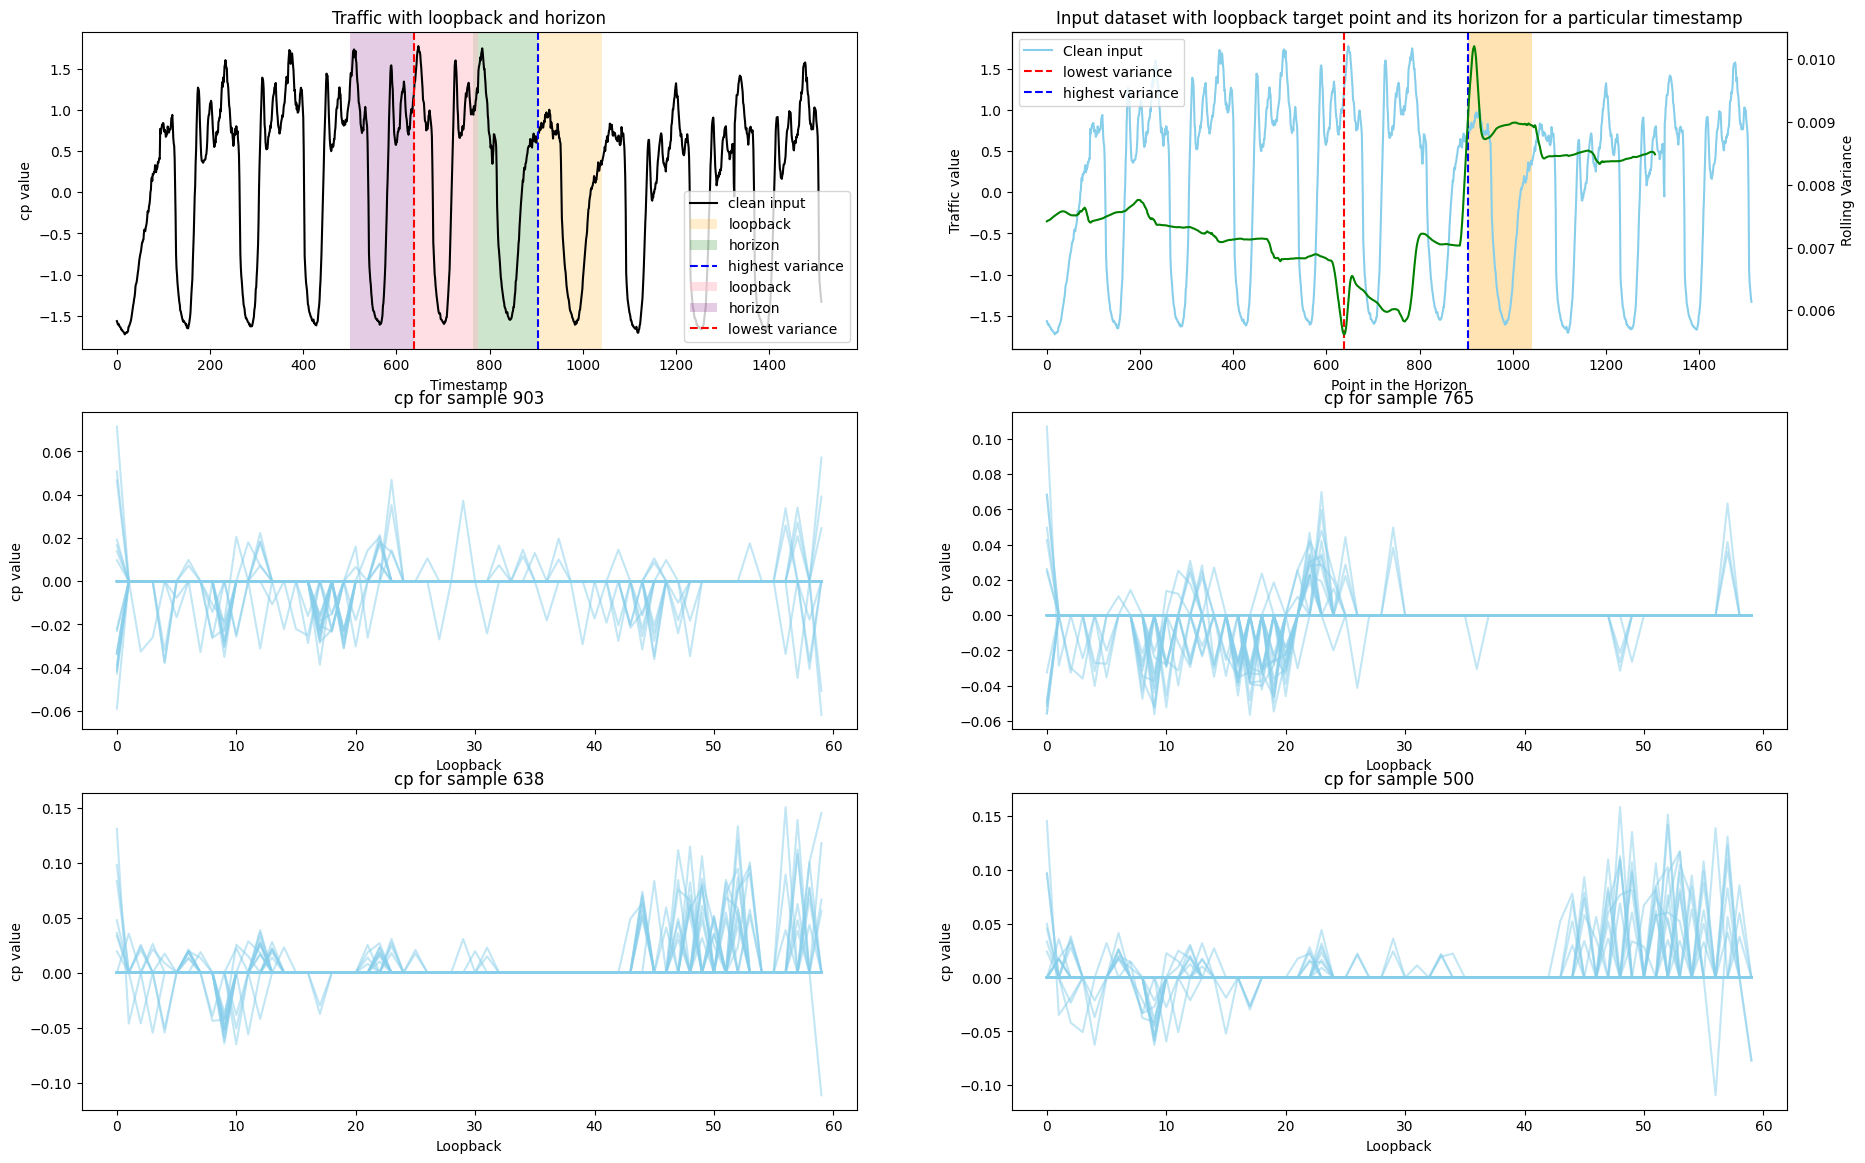

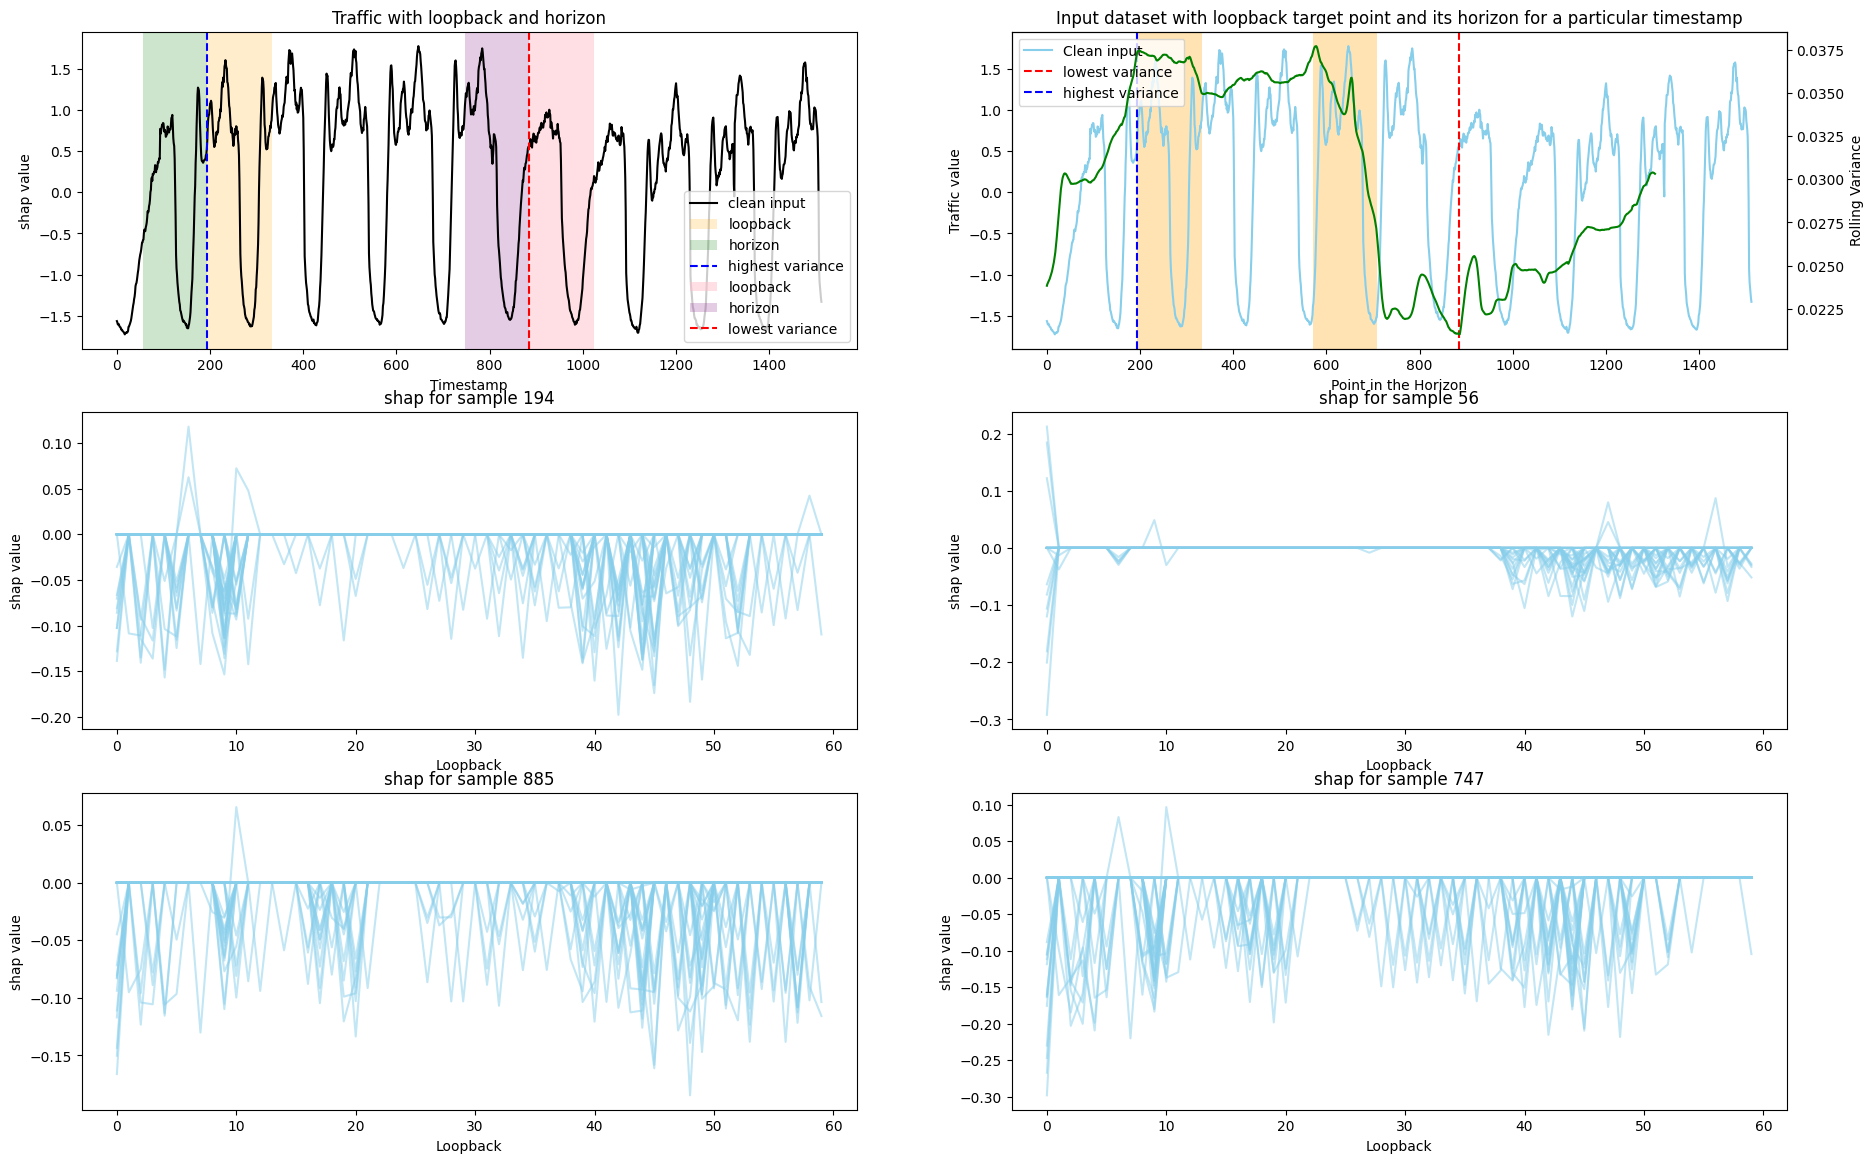

In [ ]:
# shap = model_parameters["shap_values"]
# cp = model_parameters["cp_values"]
# cln_input_flat = flatten_dataset(model_parameters["X_test"])
# cln = [cp, shap]
# dim1 = shap.shape[1]
# dim2 = shap.shape[2]

# sample = 879
# loopback = 67
# window = 138
# timestamp = sample + loopback
# first_occurence = sample - loopback
# attack='attack_rolling_var'

# for i, tensor in enumerate(results[attack]):
#     fig, axs = plt.subplots(3,2,figsize=(22,14))
#     decision_tensor = results[attack][tensor]["decision_tensor"]
#     indices = results[attack][tensor]["indices"]
#     cln_tensor = cln[i]

#     sample = indices[0]
#     loopback = 67
#     window = 138
#     timestamp = sample + loopback
#     first_occurence = sample - loopback

#     indices_low = max_peak(-decision_tensor)[0]

#     print(indices)

#     ### Input dataset with sample and loopback point
#     axs[0,0].plot(cln_input_flat, color='black', label='clean input')
#     ymin, ymax = axs[0,0].get_ylim()
#     rect = patches.Rectangle((sample, ymin), window, ymax - ymin, linewidth=0, edgecolor=None, facecolor='orange', alpha=0.2, label='loopback')
#     axs[0,0].add_patch(rect)
#     rect = patches.Rectangle((sample-window, ymin), window, ymax - ymin, linewidth=0, edgecolor=None, facecolor='green', alpha=0.2, label='horizon')
#     axs[0,0].add_patch(rect)
#     axs[0,0].axvline(sample, linestyle='--', color='blue', label='highest variance')
#     rect = patches.Rectangle((indices_low, ymin), window, ymax - ymin, linewidth=0, edgecolor=None, facecolor='pink', alpha=0.5, label='loopback')
#     axs[0,0].add_patch(rect)
#     rect = patches.Rectangle((indices_low-window, ymin), window, ymax - ymin, linewidth=0, edgecolor=None, facecolor='purple', alpha=0.2, label='horizon')
#     axs[0,0].add_patch(rect)
#     axs[0,0].axvline(indices_low, linestyle='--', color='red', label='lowest variance')
#     axs[0,0].set_xlabel('Timestamp')
#     axs[0,0].legend()
#     axs[0,0].set_ylabel(f'{tensor} value')
#     axs[0,0].set_title(f'Traffic with loopback and horizon')

#     ### tensor values for a particular sample and loopback
#     axs[0,1].plot(cln_input_flat, color='skyblue', label='Clean input')

#     ymin, ymax = axs[0,1].get_ylim()
#     for idx, point in enumerate(indices):
#         if idx == 0:
#             rect = patches.Rectangle((point, ymin), window, ymax - ymin, linewidth=0, edgecolor=None, facecolor='orange', alpha=0.3)
#             axs[0,1].add_patch(rect)
#         elif point != indices[idx-1]+1:
#             rect = patches.Rectangle((point, ymin), window, ymax - ymin, linewidth=0, edgecolor=None, facecolor='orange', alpha=0.3)
#             axs[0,1].add_patch(rect)

#     axs[0,1].set_ylabel(f'Traffic value')
#     ax2 = axs[0,1].twinx()
#     ax2.plot(decision_tensor, color='green', label=f'Rolling Variance for {tensor}')
#     ax2.set_ylabel(f'Rolling Variance')
#     axs[0,1].axvline(indices_low, linestyle='--', color='red', label='lowest variance')
#     axs[0,1].axvline(sample, linestyle='--', color='blue', label='highest variance')
#     axs[0,1].set_xlabel('Point in the Horizon')
#     axs[0,1].set_title(f'Input dataset with loopback target point and its horizon for a particular timestamp')
#     axs[0,1].legend()
    
#     axs[1,0].plot(cln[i][sample,:60,:], color="skyblue", alpha = 0.5)
#     axs[1,0].set_xlabel('Loopback')
#     axs[1,0].set_ylabel(f'{tensor} value')
#     axs[1,0].set_title(f'{tensor} for sample {sample}')

#     axs[1,1].plot(cln[i][sample-window,:60,:], color="skyblue", alpha = 0.5)
#     axs[1,1].set_xlabel('Loopback')
#     axs[1,1].set_ylabel(f'{tensor} value')
#     axs[1,1].set_title(f'{tensor} for sample {sample-window}')

#     axs[2,0].plot(cln[i][indices_low,:60,:], color="skyblue", alpha = 0.5)
#     axs[2,0].set_xlabel('Loopback')
#     axs[2,0].set_ylabel(f'{tensor} value')
#     axs[2,0].set_title(f'{tensor} for sample {indices_low}')

#     axs[2,1].plot(cln[i][indices_low-window,:60,:], color="skyblue", alpha = 0.5)
#     axs[2,1].set_xlabel('Loopback')
#     axs[2,1].set_ylabel(f'{tensor} value')
#     axs[2,1].set_title(f'{tensor} for sample {indices_low-window}')

#     fig.show()

# Time comparison

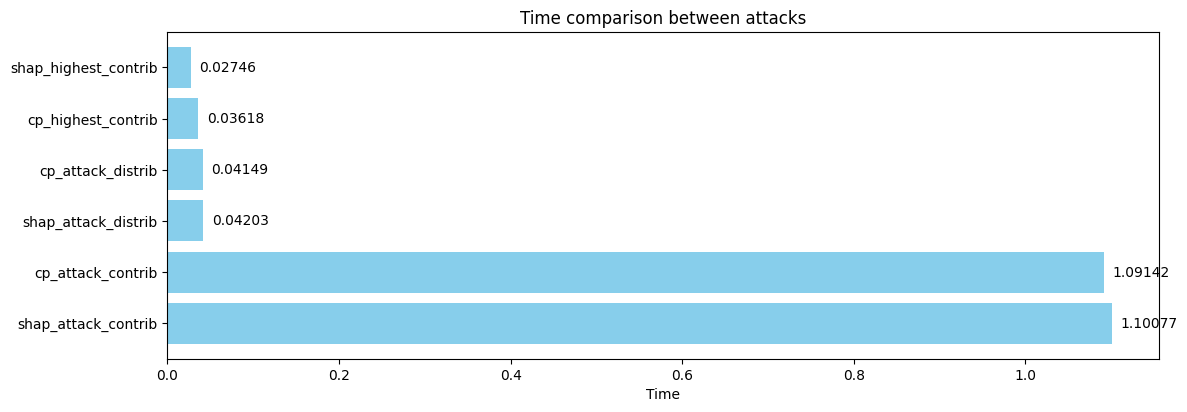

In [63]:
attacks = []
time = []

plt.figure(figsize=(12,4))
for idx, attack in enumerate(attack_list):
    for i, tensor in enumerate(tensor_list):
        marker = markers[i % len(markers)]  
        duration = results[f'{attack}_{num}_{eps}_{tensor}']["duration"]
        # print(f'{tensor}_{attack} | duration : {duration}')
        attacks.append(f'{tensor}_{attack}')
        time.append(duration)

paired = list(zip(attacks, time))
paired_sorted = sorted(paired, key=lambda x: x[1], reverse=True)
sorted_attacks, sorted_times = zip(*paired_sorted)
plt.barh(sorted_attacks, sorted_times, color='skyblue')

for i, v in enumerate(sorted_times):
    plt.text(v + 0.01, i, str(f'{v.item():.5f}'), va='center')

plt.xlabel('Time')
plt.tight_layout()
plt.title('Time comparison between attacks')
plt.show()

# Barplot

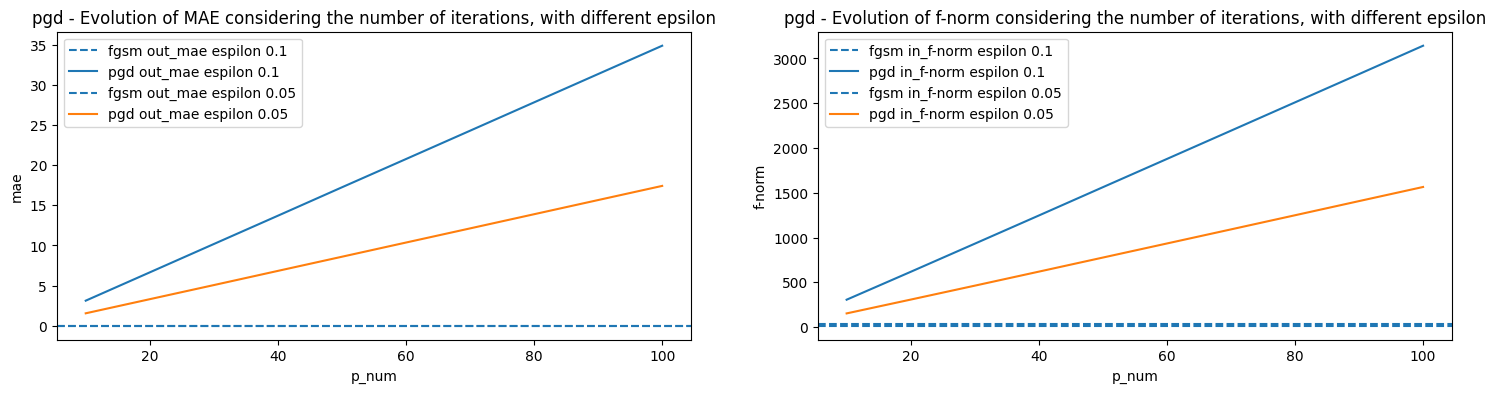

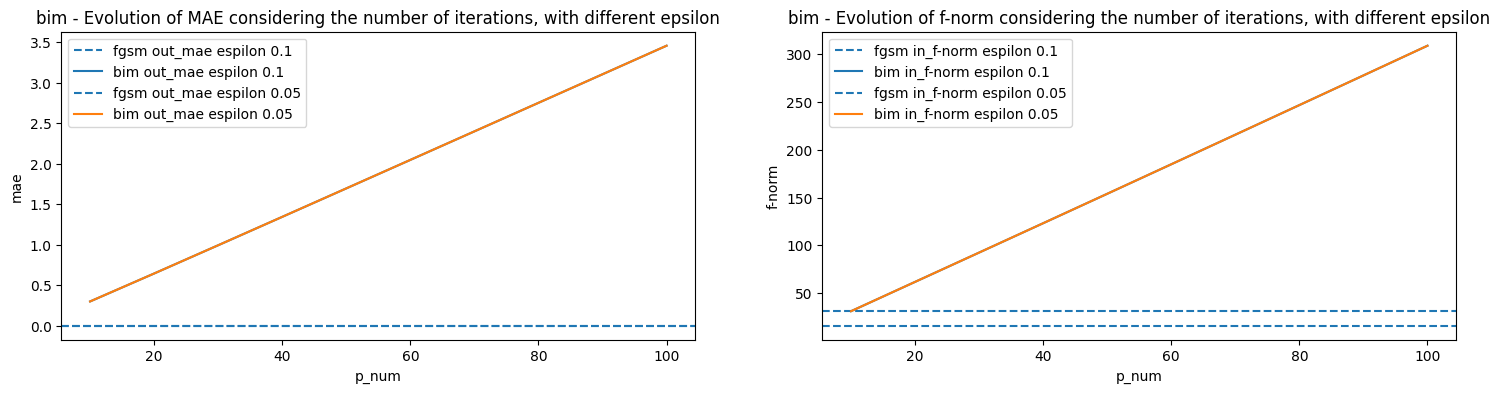

In [66]:
epsilon = [0.1,0.05]
p_num = [10,20,30,40,50,60,70,80,90,100]
for attack in ["pgd", "fgsm", "bim"]:
    if attack !="fgsm":
        fig,axs = plt.subplots(1,2,figsize=(18,4))
        for eps in epsilon:
            out_mae = []
            in_form = []
            for num in p_num:
                out_mae.append(results[f'{attack}_{num}_{eps}']['out_mae'])
                in_form.append(results[f'{attack}_{num}_{eps}']['in_fnorm'])
            fgsm = results[f'fgsm_0_{eps}']
            axs[0].axhline(fgsm['out_mae'], label=f'fgsm out_mae espilon {eps}', linestyle='--')
            axs[0].plot(p_num, out_mae, label=f'{attack} out_mae espilon {eps}')
            axs[0].set_ylabel('mae')
            axs[0].set_xlabel('p_num')
            axs[0].legend()
            axs[0].set_title(f'{attack} - Evolution of MAE considering the number of iterations, with different epsilon')

            axs[1].axhline(fgsm['in_fnorm'], label=f'fgsm in_f-norm espilon {eps}', linestyle='--')
            axs[1].plot(p_num, in_form, label=f'{attack} in_f-norm espilon {eps}')
            axs[1].set_ylabel('f-norm')
            axs[1].set_xlabel('p_num')
            axs[1].legend()
            axs[1].set_title(f'{attack} - Evolution of f-norm considering the number of iterations, with different epsilon')
            

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (2,).

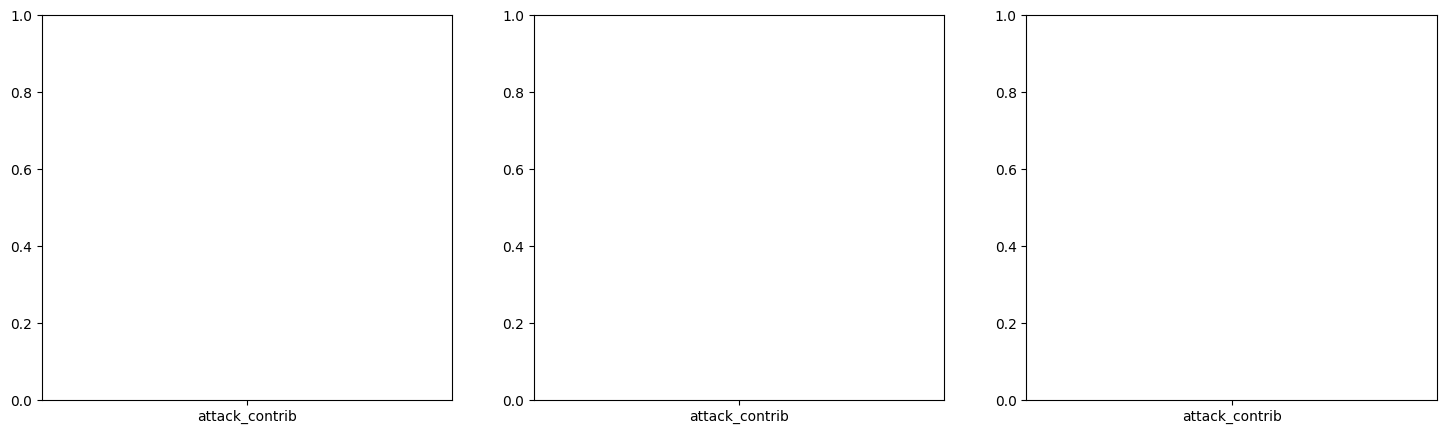

In [ ]:
# eps = 0.1
# num = 10
# mae_list = []
# mse_list = []
# num_points_list = []

# for attack in ["pgd", "bim"]:
#     key = f'{attack}_{num}_{eps}'
#     mae_list.append(results[key]['out_mae'])
#     mse_list.append(results[key]['out_mse'])
#     num_points_list.append(results[key]['num_targeted'])
    
# fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# # MAE
# axs[0].bar(attack_list, mae_list, color='skyblue')
# axs[0].set_title('MAE par attaque')
# axs[0].set_ylabel('MAE')
# axs[0].tick_params(axis='x', rotation=45)

# # MSE
# axs[1].bar(attack_list, mse_list, color='salmon')
# axs[1].set_title('MSE par attaque')
# axs[1].set_ylabel('MSE')
# axs[1].tick_params(axis='x', rotation=45)

# # Number of points
# axs[2].bar(attack_list, num_points_list, color='lightgreen')
# axs[2].set_title('Nb points ciblés par attaque')
# axs[2].set_ylabel('Nombre de points')
# axs[2].tick_params(axis='x', rotation=45)

# plt.tight_layout()
# plt.show()